## Author: Veera Marni
## Spark Assignment 2

In [4]:
from pyspark.mllib.linalg import DenseVector
import numpy as np
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import MinMaxScaler

### Loader

In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
conf = SparkConf().setMaster("local").setAppName("My App")
sc = SparkContext(conf=conf)

In [5]:
inputRDD = sc.textFile("/home/veera/Downloads/MSD.txt", 10).map(lambda line:line.split('\n'))

In [51]:
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint

def parser(x):
    x = x[0].split(',')
    return LabeledPoint(x[0], x[1:])

msd_rdd = inputRDD.map(lambda x: parser(x))

In [52]:
label_min = msd_rdd.map(lambda x: x.label).min()
print "label_min: ",label_min

def rescale_label(x, label_min):
    x.label = x.label - label_min
    return x

msd_rdd = msd_rdd.map(lambda x: rescale_label(x, label_min))
msd_subset_rdd = msd_rdd.map(lambda row: LabeledPoint(row.label, row.features[:2]))

label_min:  1922.0


In [53]:
col0_values = shifted_label_msd_rdd.map(lambda x: x.features[0])
col0_min = col0_values.min()
col0_max = col0_values.max()
col0_diff = col0_max - col0_min
col1_values = shifted_label_msd_rdd.map(lambda x: x.features[1])
col1_min = col1_values.min()
col1_max = col1_values.max()
col1_diff = col1_max - col1_min

In [57]:
print col0_min, col0_max, col0_diff, col1_min, col1_max, col1_diff

1.749 61.97014 60.22114 -337.0925 384.06573 721.15823


In [59]:
def feature_scaler(x, col0_min, col0_diff, col1_min, col1_diff):
    x.features = (x.features - [col0_min, col1_diff]) / ([col0_diff, col1_diff])
    return x

scaled_msd_rdd = msd_subset_rdd.map(lambda x: feature_scaler \
                                           (x, col0_min, col0_diff, col1_min, col1_diff))
print scaled_msd_rdd.first()

(79.0,[0.800293219291,-0.970226866856])


### Part 1

In [101]:
def gradient_cal(weights,lp):
    # compute (w.T*x-y)x 
    value = np.dot(np.dot(weights.T,lp.features)-lp.label,lp.features)
    return value

In [61]:
sample = scaled_msd_rdd.takeSample(num=2,seed=1,withReplacement=False)

In [62]:
sample_msd_rdd = sc.parallelize(sample)

In [70]:
print sample_msd_rdd.first()

(69.0,[0.260247979364,-1.04290618718])


In [63]:
weights = np.random.random(size=len(sample_msd_rdd.first().features))
gradient_value = sample_msd_rdd.map(lambda lp: gradient_cal(weights, lp))
print "Gradient"
print gradient_value.first()

Gradient
[-18.1614449   72.77936721]


### Part2

In [84]:
def predictor(weights, features):
    """
    function that takes in weight and LabeledPoint instance and returns a <label, prediction tuple>
    """
    prediction = np.dot(features, weights.T)
    return prediction

In [122]:
predictions = sample_msd_rdd.map(lambda row: (row.label, predictor(weights, row.features)))
print predictions.count()

2


### Part3
gradient descent function for linear regression

In [126]:
def gradient_descent(train, iterations=10):
    w = [np.random.random(size=len(sample_msd_rdd.first().features))]*iterations
    err = []
    train_count = train.count()
    for i in range(iterations):
        w[i] = w[i] - train.map(lambda x: gradient_cal(w[i], x)).sum()*0.01
        if i != iterations-1:
            w[i+1] = w[i]
        predictions = train.map(lambda row: (row.label, predictor(w[i], row.features)))
        rmse_err = predictions.map(lambda (y,p): (y-p)**2).reduce(lambda x,y: x+y) / train_count
        err.append(rmse_err)
    
    return w, err    

### Part4
Training model on training data and evaluating the model based on validation set after 50 iterations

In [135]:
iterations = 50
train, test = scaled_msd_rdd.randomSplit(weights=[0.2,0.2])
train, validation = train.randomSplit(weights=[0.8,0.2])
w, err = gradient_descent(train, iterations)

/home/veera/.virtualenvs/env_i524/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in double_scalars


In [171]:
val_err = validation.map(lambda row: (row.label, predictor(w[iterations-1], row.features)))
print "RMSE Validation Err: ",val_err.map(lambda (y,p): (y-p)**2).reduce(lambda x,y: x+y) / val_err.count()

RMSE Val Err:  inf


Error value to high so shown as Inf

### Part5

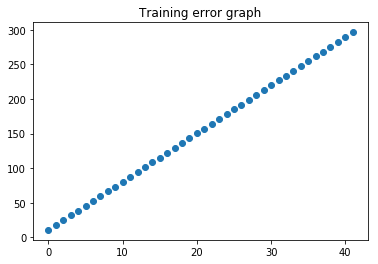

In [172]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(range(50),np.log10(np.array(err)))
plt.title("Training error graph")
plt.show()

### Part6

In [183]:
test_predictions = test.map(lambda row: (row.label, predictor(w[iterations-1], row.features)))
test_err = test_predictions.map(lambda (y,p): (y-p)**2).reduce(lambda x,y: x+y) / test_predictions.count()
print "RMSE Test Err: ",test_err

RMSE Test Err:  inf


Error value to high so shown as Inf